# <center>A review on meta learning initialization based techniques for few shot learning </center>

In this notebook we will explore the main trends in the field of initialization based techniques for few shot learning. We will present 3 algorithms following their publication order. 
<ul>
  <li>Model Agnostic Meta Learning</li>
  <li>First Order MAML</li>
  <li>REPTILE</li>
</ul> 
The initialization based techniques 
Each of them is an evolution, or as we will explain, a simplification of the previous version. Since REPTILE gives the best trade-off between accuracy and complexity, it's the one we will implement using TensorFlow.

## Model Agnostic Meta Learning (MAML)
Model-Agnostic Meta-Learning (Finn et al. '17), was one of the first algorithm that tried to learn the best initialization in a meta learning context.  The goal of this process is to achieve an optimal fast learning on a new task with only a small number of gradient steps while avoiding overfitting that may happen when using a small dataset. To do so, MAML uses the following algorithm.

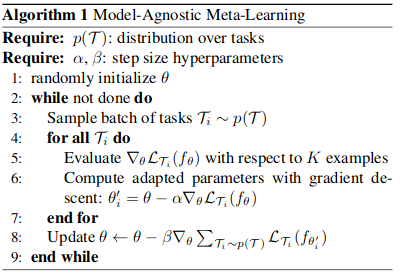

This algorithm is called "Model agnostic" because we can use it with any model, we just have to change the loss function according to the problematic we want to solve. By example for a regression problem we can use a mean squared error loss, and in the case of a classification problem we can use a cross-entropy loss. In this notebook we will focus only on the few-shots classification problem.    

## MAML : the way it works

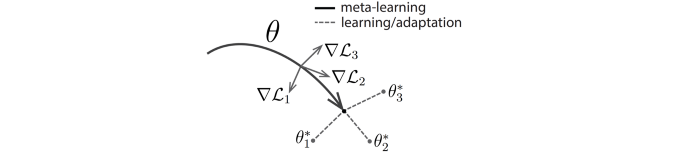

In the diagram above, θ is the model’s parameters and the bold black line is the meta-learning phase. When we have, for example, 3 different new tasks 1, 2 and 3, a gradient step is taken for each task (the gray lines) this phase is called "inner loop". We can now compute a meta loss using the results of this inner loop and then update the meta-parameters (bold line). We can see that the parameters θ are close to all the 3 optimal parameters of task 1, 2, and 3 which makes θ the best parameters initialization that can quickly adapt to different new tasks. As a result, only a small change in the parameters θ will lead to an optimal minimization of the loss function of any task.

From a mathematical point of view, for a distribution of tasks $p(T)$ the meta-parameters are updated as follow : 

$$\theta \leftarrow \theta-\beta \nabla_{\theta} \sum_{\mathcal{T}_{i} \sim p(T)} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)\ with :\
\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)
$$


$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$

$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})}\left(\nabla_{\theta} \theta_{i}^{\prime}\right) \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$
$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})}\left(I-\alpha \nabla_{\theta}^{2} \mathcal{L}_{\mathcal{T},}\left(f_{\theta}\right)\right) \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$

This second order derivative is an important issue because the implementation is trickier and it creates a way more complicated graph for the automatic differentiation, that requires a large amount of memory, resulting in a much longer training time. 

To make the computation less expensive, a modified version of MAML omits second derivatives, resulting in a simplified and cheaper implementation, known as First-Order MAML (FOMAML).

## First order MAML

The idea of a first order approximation for MAML was discussed in the original paper but a better version was proposed in "On First-Order Meta-Learning Algorithms" (Nichol and al. 18). The algorithm for this version of FO-MAML is given below : 

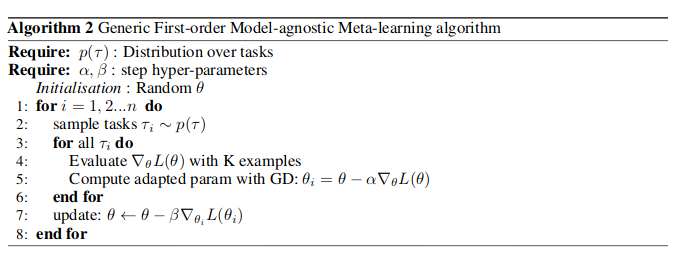

1. Sample $N$ tasks from the space of tasks
2. For each task $τ_i$, compute one iteration of gradient, leading to new parameters $θ_i$
3. Compute the meta-gradient at $θ_i$(rather than $θ$ as in MAML)
4. Average the $N$ such gradients obtained from the $N$ tasks

We can use the same inner loop 

$$\theta \leftarrow \theta-\beta \nabla_{\theta} \sum_{\mathcal{T}_{i} \sim p(T)} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)\ with :\
\theta_{i}^{\prime}=\theta-\alpha \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta}\right)
$$


$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$

$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})}\left(\nabla_{\theta} \theta_{i}^{\prime}\right) \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$
$$
=\theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})}\left(I-\alpha \nabla_{\theta}^{2} \mathcal{L}_{\mathcal{T},}\left(f_{\theta}\right)\right) \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)
$$

Past work has observed that ReLU neural networks are locally almost linear (Goodfellow et al.,2015), which suggests that second derivatives may be close to zero in most cases, partially explaining the good performance of the first-order approximation.  

$$
\approx \theta-\beta \sum_{\mathcal{T}_{i} \sim p(\mathcal{T})} \nabla_{\theta_{i}^{\prime}} \mathcal{L}_{\mathcal{T}_{i}}\left(f_{\theta_{i}^{\prime}}\right)\ with : \left(I-\alpha \nabla_{\theta}^{2} \mathcal{L}_{\mathcal{T},}\left(f_{\theta}\right)\right) = I 
$$

While it doesn’t contain second-derivative terms, the resulting method still computes the meta-gradient at the post-update parameter values θi. The performance of this method is nearly the same as that obtained with full second derivatives, suggesting that majority constituent of the MAML improvement is from the gradients of the objective at the post-update parameter values and that the second order updates from differentiating through the gradient updates are less significant as explained in the Goodfellow et al paper. 

This approximation removes the need for computing Hessian-vector products in an additional backward pass, which led to roughly 33% speed-up in network computation according to the original paper.

In the figure below you can see two different PyTorch autograd graph for 1st order MAML (left) and 2nd order MAML (right) with one inner training step.

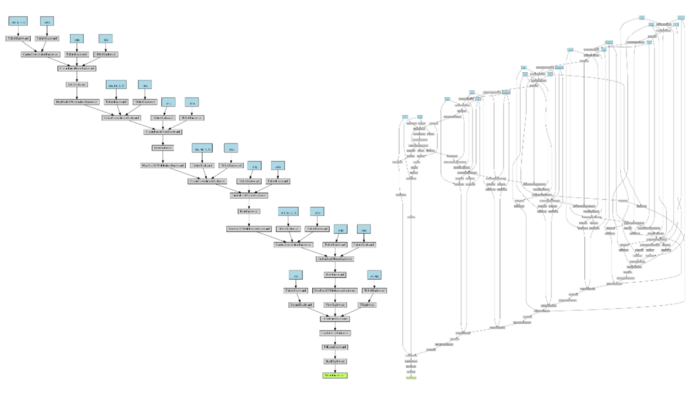

### Reptile

Reptile (Nichol & al. 2018) is a remarkably simple meta-learning optimization algorithm. It is similar to FOMAML in many ways, both rely on meta-optimization through gradient descent and both are model-agnostic.



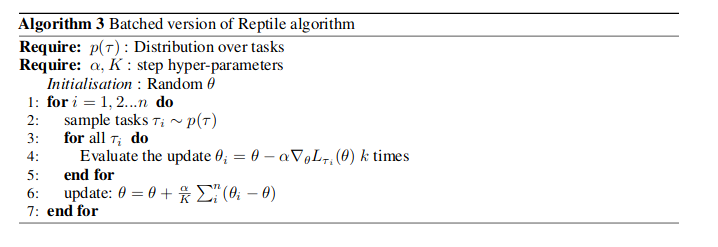

The algoithm is very simple :

    1. sample a task,
    2. train on it by multiple gradient descent steps
    3. and then move the model meta-weights towards the new parameters.

We just want to move our initialization weights a little bit in the direction of the weights we obtained after your k iterations of SGD.

It has been shown in Nichol & al. 2018 that Reptile and MAML yield similar performance on the Omniglot and Mini-ImageNet benchmarks for few-shot classification. Reptile also converges to the solution faster, that's why we choosed to implement this algorithm.

## Reptile implementation

(Make sure to launch all the cells in the netbook order)

In [2]:
import random
import sys
import importlib
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm_notebook as tqdm
from supervised_reptile.models import MiniImageNetModel
from supervised_reptile.variables import VariableState,add_vars,average_vars,interpolate_vars,scale_vars,subtract_vars,weight_decay


In [3]:
"""
Build opt object containing all the hyperparameters
"""

class opt(object):
    def __init__(self, pretrained=False,seed=0,checkpoint="model_checkpoint",classes=20,shots=5,train_shots=0,inner_batch=5,
                inner_iters=10,learning_rate=1e-3,meta_step=0.1,meta_step_final=0.1,meta_batch=1,meta_iters=1000,eval_batch=5
                 ,eval_iters=10,eval_samples=100,eval_interval=10,weight_decay=1,foml=False,foml_tail=0,sgd=False,
                 replacement=False,transductive=False,curves=False,verbose=True,dataset="omniglot"):
        
        self.pretrained = pretrained
        self.seed = seed
        self.checkpoint = checkpoint
        self.classes = classes
        self.shots = shots 
        self.train_shots = train_shots
        self.inner_batch = inner_batch
        self.inner_iters = inner_iters
        self.learning_rate = learning_rate
        self.meta_step = meta_step
        self.meta_step_final = meta_step_final
        self.meta_batch = meta_batch
        self.meta_iters = meta_iters 
        self.eval_batch = eval_batch
        self.eval_iters = eval_iters
        self.eval_samples = eval_samples
        self.eval_interval = eval_interval
        self.weight_decay = weight_decay
        self.foml = foml 
        self.foml_tail = foml_tail
        self.sgd = sgd
        self.replacement = replacement
        self.transductive = transductive
        self.curves = curves
        self.verbose = verbose
        self.dataset = dataset



def model_kwargs(parsed_args):
    """
    Build the kwargs for model constructors from the
    parsed command-line arguments.
    """
    res = {'learning_rate': parsed_args.learning_rate}
    if parsed_args.sgd:
        res['optimizer'] = tf.train.GradientDescentOptimizer
    return res

def train_kwargs(parsed_args):
    """
    Build kwargs for the train() function from the parsed
    command-line arguments.
    """
    return {
        'num_classes': parsed_args.classes,
        'num_shots': parsed_args.shots,
        'train_shots': (parsed_args.train_shots or None),
        'inner_batch_size': parsed_args.inner_batch,
        'inner_iters': parsed_args.inner_iters,
        'replacement': parsed_args.replacement,
        'meta_step_size': parsed_args.meta_step,
        'meta_step_size_final': parsed_args.meta_step_final,
        'meta_batch_size': parsed_args.meta_batch,
        'meta_iters': parsed_args.meta_iters,
        'eval_inner_batch_size': parsed_args.eval_batch,
        'eval_inner_iters': parsed_args.eval_iters,
        'eval_interval': parsed_args.eval_interval,
        'weight_decay_rate': parsed_args.weight_decay,
        'transductive': parsed_args.transductive,
        'reptile_fn': _args_reptile(parsed_args),
        'curves': parsed_args.curves,
        'verbose' : parsed_args.verbose,
        'dataset' : parsed_args.dataset
    }

def evaluate_kwargs(parsed_args):
    """
    Build kwargs for the evaluate() function from the
    parsed command-line arguments.
    """
    return {
        'num_classes': parsed_args.classes,
        'num_shots': parsed_args.shots,
        'eval_inner_batch_size': parsed_args.eval_batch,
        'eval_inner_iters': parsed_args.eval_iters,
        'replacement': parsed_args.replacement,
        'weight_decay_rate': parsed_args.weight_decay,
        'num_samples': parsed_args.eval_samples,
        'transductive': parsed_args.transductive,
        'reptile_fn': _args_reptile(parsed_args)
    }

def _args_reptile(parsed_args):
    if parsed_args.foml:
        return partial(FOML, tail_shots=parsed_args.foml_tail)
    return Reptile

    

In [4]:
"""
Loading and augmenting the Omniglot dataset.

To use these APIs, you should prepare a directory that
contains all of the alphabets from both images_background
and images_evaluation.
"""

import os
import random

import numpy as np

def read_dataset(data_dir):
    """
    Iterate over the characters in a data directory.

    Args:
      data_dir: a directory of alphabet directories.

    Returns:
      An iterable over Characters.

    The dataset is unaugmented and not split up into
    training and test sets.
    """
    for alphabet_name in sorted(os.listdir(data_dir)):
        alphabet_dir = os.path.join(data_dir, alphabet_name)
        if not os.path.isdir(alphabet_dir):
            continue
        for char_name in sorted(os.listdir(alphabet_dir)):
            if not char_name.startswith('character'):
                continue
            yield Character(os.path.join(alphabet_dir, char_name), 0)

def split_dataset(dataset, num_train=1200):
    """
    Split the dataset into a training and test set.

    Args:
      dataset: an iterable of Characters.

    Returns:
      A tuple (train, test) of Character sequences.
    """
    all_data = list(dataset)
    random.shuffle(all_data)
    return all_data[:num_train], all_data[num_train:]

def augment_dataset(dataset):
    """
    Augment the dataset by adding 90 degree rotations.

    Args:
      dataset: an iterable of Characters.

    Returns:
      An iterable of augmented Characters.
    """
    for character in dataset:
        for rotation in [0, 90, 180, 270]:
            yield Character(character.dir_path, rotation=rotation)

# pylint: disable=R0903
class Character:
    """
    A single character class.
    """
    def __init__(self, dir_path, rotation=0):
        self.dir_path = dir_path
        self.rotation = rotation
        self._cache = {}

    def sample(self, num_images):
        """
        Sample images (as numpy arrays) from the class.

        Returns:
          A sequence of 28x28 numpy arrays.
          Each pixel ranges from 0 to 1.
        """
        names = [f for f in os.listdir(self.dir_path) if f.endswith('.png')]
        random.shuffle(names)
        images = []
        for name in names[:num_images]:
            images.append(self._read_image(os.path.join(self.dir_path, name)))
        return images

    def _read_image(self, path):
        if path in self._cache:
            return self._cache[path]
        with open(path, 'rb') as in_file:
            img = Image.open(in_file).resize((28, 28)).rotate(self.rotation)
            self._cache[path] = np.array(img).astype('float32')
            return self._cache[path]


In [5]:
from functools import partial

DEFAULT_OPTIMIZER = partial(tf.train.AdamOptimizer, beta1=0)


class OmniglotModel:
    """
    A model for Omniglot classification.
    """
    def __init__(self, num_classes, optimizer=DEFAULT_OPTIMIZER, **optim_kwargs):
        self.input_ph = tf.placeholder(tf.float32, shape=(None, 28, 28))
        out = tf.reshape(self.input_ph, (-1, 28, 28, 1))
        for _ in range(4):
            out = tf.layers.conv2d(out, 64, 3, strides=2, padding='same')
            out = tf.layers.batch_normalization(out, training=True)
            out = tf.nn.relu(out)
        out = tf.reshape(out, (-1, int(np.prod(out.get_shape()[1:]))))
        self.logits = tf.layers.dense(out, num_classes)
        self.label_ph = tf.placeholder(tf.int32, shape=(None,))
        self.loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=self.label_ph,
                                                                   logits=self.logits)
        self.predictions = tf.argmax(self.logits, axis=-1)
        self.minimize_op = optimizer(**optim_kwargs).minimize(self.loss)

In [6]:
class Reptile:
    """
    A meta-learning session.

    Reptile can operate in two evaluation modes: normal
    and transductive. In transductive mode, information is
    allowed to leak between test samples via BatchNorm.
    Typically, MAML is used in a transductive manner.
    """
    def __init__(self, session, variables=None, transductive=False, pre_step_op=None):
        self.session = session
        self._model_state = VariableState(self.session, variables or tf.trainable_variables())
        self._full_state = VariableState(self.session,
                                         tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES))
        self._transductive = transductive
        self._pre_step_op = pre_step_op

    # pylint: disable=R0913,R0914
    def train_step(self,
                   dataset,
                   input_ph,
                   label_ph,
                   minimize_op,
                   num_classes,
                   num_shots,
                   inner_batch_size,
                   inner_iters,
                   replacement,
                   meta_step_size,
                   meta_batch_size):
        """
        Perform a Reptile training step.

        Args:
          dataset: a sequence of data classes, where each data
            class has a sample(n) method.
          input_ph: placeholder for a batch of samples.
          label_ph: placeholder for a batch of labels.
          minimize_op: TensorFlow Op to minimize a loss on the
            batch specified by input_ph and label_ph.
          num_classes: number of data classes to sample.
          num_shots: number of examples per data class.
          inner_batch_size: batch size for every inner-loop
            training iteration.
          inner_iters: number of inner-loop iterations.
          replacement: sample with replacement.
          meta_step_size: interpolation coefficient.
          meta_batch_size: how many inner-loops to run.
        """
        old_vars = self._model_state.export_variables()
        new_vars = []
        for _ in range(meta_batch_size):
            mini_dataset = _sample_mini_dataset(dataset, num_classes, num_shots)
            for batch in _mini_batches(mini_dataset, inner_batch_size, inner_iters, replacement):
                inputs, labels = zip(*batch)
                if self._pre_step_op:
                    self.session.run(self._pre_step_op)
                self.session.run(minimize_op, feed_dict={input_ph: inputs, label_ph: labels})
            new_vars.append(self._model_state.export_variables())
            self._model_state.import_variables(old_vars)
        new_vars = average_vars(new_vars)
        self._model_state.import_variables(interpolate_vars(old_vars, new_vars, meta_step_size))

    def evaluate(self,
                 dataset,
                 input_ph,
                 label_ph,
                 minimize_op,
                 predictions,
                 num_classes,
                 num_shots,
                 inner_batch_size,
                 inner_iters,
                 replacement):
        """
        Run a single evaluation of the model.

        Samples a few-shot learning task and measures
        performance.

        Args:
          dataset: a sequence of data classes, where each data
            class has a sample(n) method.
          input_ph: placeholder for a batch of samples.
          label_ph: placeholder for a batch of labels.
          minimize_op: TensorFlow Op to minimize a loss on the
            batch specified by input_ph and label_ph.
          predictions: a Tensor of integer label predictions.
          num_classes: number of data classes to sample.
          num_shots: number of examples per data class.
          inner_batch_size: batch size for every inner-loop
            training iteration.
          inner_iters: number of inner-loop iterations.
          replacement: sample with replacement.

        Returns:
          The number of correctly predicted samples.
            This always ranges from 0 to num_classes.
        """
        train_set, test_set = _split_train_test(
            _sample_mini_dataset(dataset, num_classes, num_shots+1))
        old_vars = self._full_state.export_variables()
        #for inner iters
        for batch in _mini_batches(train_set, inner_batch_size, inner_iters, replacement):
            inputs, labels = zip(*batch)
            #labels size = inner_batch_size
            #if self._pre_step_op:
            #    self.session.run(self._pre_step_op)
            self.session.run(minimize_op, feed_dict={input_ph: inputs, label_ph: labels})
        test_preds = self._test_predictions(train_set, test_set, input_ph, predictions)
        num_correct = sum([pred == sample[1] for pred, sample in zip(test_preds, test_set)])
        self._full_state.import_variables(old_vars)
        return num_correct

    def _test_predictions(self, train_set, test_set, input_ph, predictions):
        if self._transductive:
            inputs, _ = zip(*test_set)
            return self.session.run(predictions, feed_dict={input_ph: inputs})
        res = []

        for test_sample in test_set:
            inputs, _ = zip(*train_set)
            inputs += (test_sample[0],)
            res.append(self.session.run(predictions, feed_dict={input_ph: inputs})[-1])
        return res



def _sample_mini_dataset(dataset, num_classes, num_shots):
    """
    Sample a few shot task from a dataset.

    Returns:
      An iterable of (input, label) pairs.
    """
    shuffled = list(dataset)
    random.shuffle(shuffled)
    for class_idx, class_obj in enumerate(shuffled[:num_classes]):
        for sample in class_obj.sample(num_shots):
            yield (sample, class_idx)

def _mini_batches(samples, batch_size, num_batches, replacement):
    """
    Generate mini-batches from some data.

    Returns:
      An iterable of sequences of (input, label) pairs,
        where each sequence is a mini-batch.
    """
    samples = list(samples)
    if replacement:
        for _ in range(num_batches):
            yield random.sample(samples, batch_size)
        return
    cur_batch = []
    batch_count = 0
    while True:
        random.shuffle(samples)
        for sample in samples:
            cur_batch.append(sample)
            if len(cur_batch) < batch_size:
                continue
            yield cur_batch
            cur_batch = []
            batch_count += 1
            if batch_count == num_batches:
                return

def _split_train_test(samples, test_shots=1):
    """
    Split a few-shot task into a train and a test set.

    Args:
      samples: an iterable of (input, label) pairs.
      test_shots: the number of examples per class in the
        test set.

    Returns:
      A tuple (train, test), where train and test are
        sequences of (input, label) pairs.
    """
    train_set = list(samples)
    test_set = []
    labels = set(item[1] for item in train_set)
    for _ in range(test_shots):
        for label in labels:
            for i, item in enumerate(train_set):
                if item[1] == label:
                    del train_set[i]
                    test_set.append(item)
                    break
    if len(test_set) < len(labels) * test_shots:
        raise IndexError('not enough examples of each class for test set')
    return train_set, test_set


In [7]:
def plot_dist_proto(acc_train,acc_test,metaiter):
    """Plot training accuracy and testing accuracy"""
    sns.set()
    dic_data = {"acc_train":acc_train,"acc_test":acc_test}
    df = pd.DataFrame(data=dic_data)
    df["ind"] = pd.Series(range(0,len(acc_train)*10,10))
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 7))
    sns.lineplot(data=df, x="ind", y="acc_train", ax=ax1, label="acc_train")
    sns.lineplot(data=df, x="ind", y ="acc_test", ax=ax2, label = "acc_test")
    ax1.set(xlabel = "Meta iterations", ylabel = "Accuracy (%)" )
    ax2.set(xlabel="Meta iterations", ylabel= "Accuracy (%)")
    ax1.grid(True, which="both", c='white')
    ax2.grid(True, which="both", c='white')
    f.suptitle("Accuracy curves for train and test sets")

def train(sess,
          model,
          train_set,
          test_set,
          save_dir,
          num_classes=5,
          num_shots=5,
          inner_batch_size=5,
          inner_iters=20,
          replacement=False,
          meta_step_size=0.1,
          meta_step_size_final=0.1,
          meta_batch_size=1,
          meta_iters=400000,
          eval_inner_batch_size=5,
          eval_inner_iters=50,
          eval_interval=10,
          weight_decay_rate=1,
          time_deadline=None,
          train_shots=None,
          transductive=False,
          reptile_fn=Reptile,
          log_fn=print,
          curves = False,
          verbose = True,
          dataset = "omniglot"):
    """
    Train a model on a dataset.
    """
    global_acc_train = []
    global_acc_test = []
    eval_kwargs = evaluate_kwargs(args)
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    saver = tf.train.Saver()
    reptile = reptile_fn(sess,
                         transductive=transductive,
                         pre_step_op=weight_decay(weight_decay_rate))
    accuracy_ph = tf.placeholder(tf.float32, shape=())
    tf.summary.scalar('accuracy', accuracy_ph)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(os.path.join(save_dir, 'train'), sess.graph)
    test_writer = tf.summary.FileWriter(os.path.join(save_dir, 'test'), sess.graph)
    tf.global_variables_initializer().run()
    sess.run(tf.global_variables_initializer())
    if curves == True:
        global_acc_train.append(evaluate_val(sess, model, train_set, **eval_kwargs))
        global_acc_test.append(evaluate_val(sess, model, test_set, **eval_kwargs))
    for i in tqdm(range(meta_iters)):
        frac_done = i / meta_iters
        cur_meta_step_size = frac_done * meta_step_size_final + (1 - frac_done) * meta_step_size
        reptile.train_step(train_set, model.input_ph, model.label_ph, model.minimize_op,
                           num_classes=num_classes, num_shots=(train_shots or num_shots),
                           inner_batch_size=inner_batch_size, inner_iters=inner_iters,
                           replacement=replacement,
                           meta_step_size=cur_meta_step_size, meta_batch_size=meta_batch_size)
        if i % eval_interval == 0:
            if curves == True:
                global_acc_train.append(evaluate_val(sess, model, train_set, **eval_kwargs))
                global_acc_test.append(evaluate_val(sess, model, test_set, **eval_kwargs))
            accuracies = []
            for dataset, writer in [(train_set, train_writer), (test_set, test_writer)]:
                correct = reptile.evaluate(dataset, model.input_ph, model.label_ph,
                                           model.minimize_op, model.predictions,
                                           num_classes=num_classes, num_shots=num_shots,
                                           inner_batch_size=eval_inner_batch_size,
                                           inner_iters=eval_inner_iters, replacement=replacement)
                summary = sess.run(merged, feed_dict={accuracy_ph: correct/num_classes})
                writer.add_summary(summary, i)
                writer.flush()
                accuracies.append(correct / num_classes)
    
            if verbose == True:
                log_fn('batch %d: train=%f test=%f' % (i, accuracies[0], accuracies[1]))
        
        if i % 100 == 0 or i == meta_iters-1:
            saver.save(sess, os.path.join(save_dir, 'model.ckpt'), global_step=i)
        if time_deadline is not None and time.time() > time_deadline:
            break
    return global_acc_train,global_acc_test


In [8]:
def evaluate_val(sess,
             model,
             dataset,
             num_classes=5,
             num_shots=5,
             eval_inner_batch_size=5,
             eval_inner_iters=50,
             replacement=False,
             num_samples=10,
             transductive=False,
             weight_decay_rate=1,
             reptile_fn=Reptile):
    """
    Evaluate a model on a dataset.
    """
    reptile = reptile_fn(sess,
                         transductive=transductive,
                         pre_step_op=weight_decay(weight_decay_rate))
    total_correct = 0
  
    #valid static
    for _ in range(num_samples):
        total_correct += reptile.evaluate(dataset, model.input_ph, model.label_ph,
                                          model.minimize_op, model.predictions,
                                          num_classes=num_classes, num_shots=num_shots,
                                          inner_batch_size=eval_inner_batch_size,
                                          inner_iters=eval_inner_iters, replacement=replacement)
    return total_correct / (num_samples * num_classes)


## Training on Omniglot 5 shots 5 way
The REPTILE algorithm requires an important number of meta iterations to reach a strong accuracy, the training might be long especially if the argument "curves" is True (evaluates the train and test every n epochs). You might want to use tensorboard instead.  

In [9]:
def main_omniglot(args):
    """
    Load data and train a model on it.
    """
    tf.reset_default_graph() 

    random.seed(args.seed)

    train_set, test_set = split_dataset(read_dataset(DATA_DIR))
  
   #print(train_set[0].sample(8)[0].shape)
    train_set = list(augment_dataset(train_set))
    test_set = list(test_set)
    model = OmniglotModel(args.classes, **model_kwargs(args))

    with tf.Session() as sess:
        if not args.pretrained:
            print('Training...')
            train_acc , test_acc =train(sess, model, train_set, test_set, args.checkpoint, **train_kwargs(args))
            print(train_acc,test_acc)
        else:
            print('Restoring from checkpoint...')
            tf.train.Saver().restore(sess, tf.train.latest_checkpoint(args.checkpoint))

        print('Evaluating...')
        eval_kwargs = evaluate_kwargs(args)
         
        print('Train accuracy: ' + str(evaluate_val(sess, model, train_set, **eval_kwargs)))
        print('Test accuracy: ' + str(evaluate_val(sess, model, test_set, **eval_kwargs)))
    if args.curves == True:
        plot_dist_proto(train_acc,test_acc)


In [ ]:
DATA_DIR = "./data/omniglot/"
args = opt(curves=False,meta_iters=100000,transductive=True,eval_interval=50,dataset="omniglot",eval_samples=500)
main_omniglot(args)

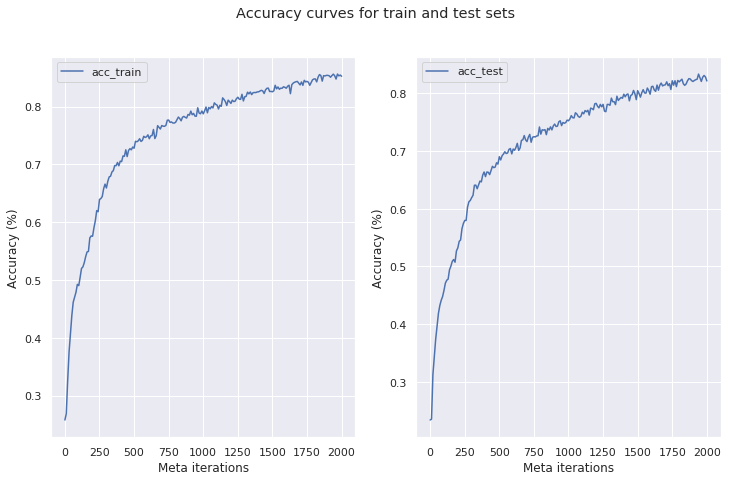

On the figure below we have the results for MAML, FOMAML and Reptile for the Omniglot dataset. The results are really close for FOMAML and Reptile. On the other hand, when the number of ways increase MAML seems to perform better. 

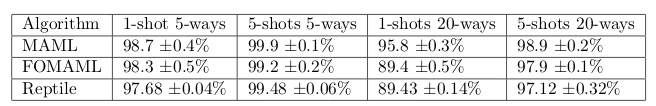

## Composition of different inner loop gradient

The figure below was taken from the OpenAI original paper and shows different inner-loop combinations on 5-shot 5-way Ominiglot. They used four non-overlapping mini-batches in each inner-loop, yielding gradients g1, g2, g3, and g 4.Then they compared learning performance when using different linear combinations  of  the gi’s for  the  outer  loop update. As expected if we use only the first gradient g1 to update the outer loop it results in a very bad accuracy since we ignore the other directions.  

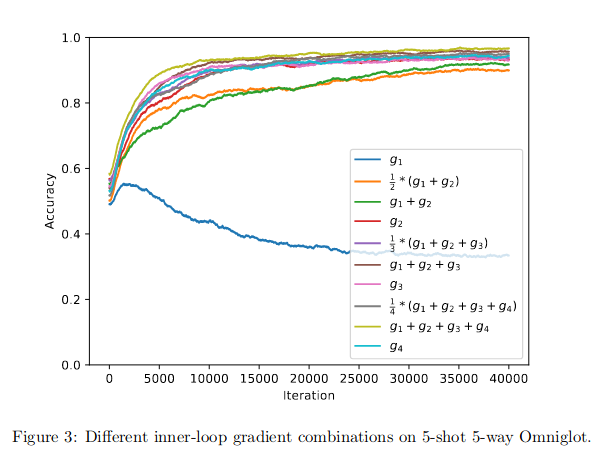

## Training mini-imagenet 5 shots 5 ways

You can also run the training as a script : 

In [3]:
!python -u run_miniimagenet.py --inner-batch 10 --inner-iters 8 --meta-step 1 --meta-batch 5 --meta-iters 1000 --eval-batch 15 --eval-iters 50 --learning-rate 0.001 --meta-step-final 0 --train-shots 15


2019-08-12 16:18:09.824555: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2019-08-12 16:18:09.930971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:964] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-08-12 16:18:09.931354: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: TITAN V major: 7 minor: 0 memoryClockRate(GHz): 1.455
pciBusID: 0000:01:00.0
totalMemory: 11.78GiB freeMemory: 11.31GiB
2019-08-12 16:18:09.931370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-08-12 16:18:10.228074: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-08-12 16:18:10.228105: I tensorflow/core/common_runtime/gpu/gpu_device.cc:98

The results for the mini-imagenet dataset are shown below, we can observe that Reptile results outperform MAML. It might be interesting to have a look at the results for a 20 ways scenario where MAML should normally perfoms better.

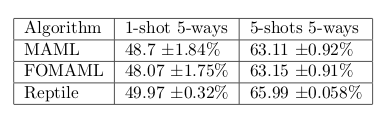

### Impact of the number of classes in the meta-train set

We want now to estimate how much classes do we need to train our algorithm. To do so, we will apply a subsampling method on the omniglot dataset. 

Omniglot contains 1623 classes (characters) We will keep the last 400 for the test and we will random sample $n$ classes from the meta-train.    

In [9]:
import matplotlib.pyplot as plt
DATA_DIR = '/home/neucod/Adrien/reptile-pytorch/omniglot/'
args = opt(curves=False,meta_iters=10000,transductive=True,verbose=False)

def sub_sample_train(i,out):
    #random.seed(args.seed)
    print(type(args.seed))
    tf.reset_default_graph() 
    #args = opt(curves=False,meta_iters=10000,transductive=True,verbose=False)
    eval_kwargs = evaluate_kwargs(args)
    #random.seed(args.seed)
    train_set, test_set = split_dataset(read_dataset(DATA_DIR),i)
    test_set = random.sample(test_set, out)
    
    #train_set = list(augment_dataset(train_set))
    test_set = list(test_set)
    print("len train",len(train_set))
    print("len test ", len(test_set))
    model = OmniglotModel(args.classes, **model_kwargs(args))
    with tf.Session() as sess:

        train_acc , test_acc =train(sess, model, train_set, test_set, args.checkpoint, **train_kwargs(args))
        test = evaluate_val(sess, model, test_set, **eval_kwargs)
        print('Test accuracy: ' + str(test))
        print("len train",len(train_set))

        
        print("len test ", len(test_set))
    return test
        


Text(0.5,0.98,'Accuracy when sub-sampling the meta-train set (meta-testing on 300 classes)')

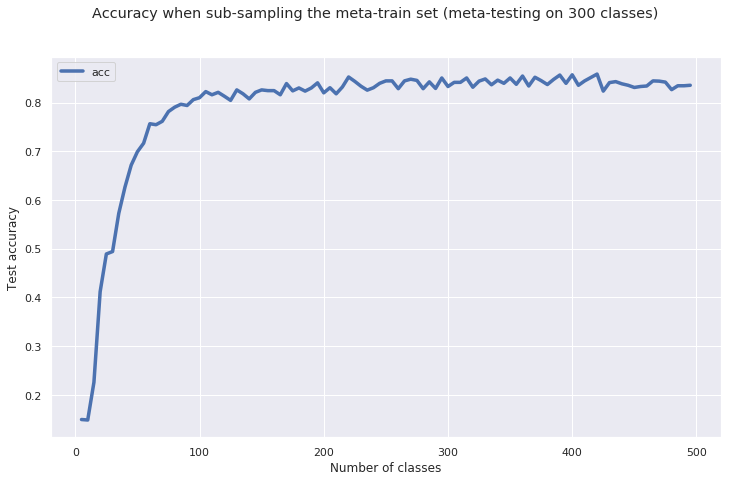

In [40]:
acc = []
for i in tqdm(range(0,500,5)):
    tf.reset_default_graph() 
    acc.append(sub_sample_train(i,300))
    
sns.set(rc={"lines.linewidth": 3.5})
f, ax= plt.subplots(1,1,figsize=(12, 7))
dic_data = {"Test accuracy":acc}
df = pd.DataFrame(data=dic_data)
df["Number of classes"] = pd.Series(range(5,len(acc)*5,5))
sns.lineplot(data=df, x="Number of classes", y="Test accuracy", ax=ax, label="acc",err_style='bars')

f.suptitle("Accuracy when sub-sampling the meta-train set (meta-testing on 300 classes)")

It is almost impossible to estimate the number of classes needed to perform on another dataset since the problem is dataset dependent but this curve is interesting at least for two reasons. First, the curve is really smooth it means that adding a new classe in the meta-train has a huge influence on the result of the meta-test. Moreover there is  a saturation (after n = 100). To estimate if you have enough classe on a new dataset, you can just plot this curve and see if you are in the saturation zone or in the "learning" zone. 

### Conclusion 

We have presented three initialization based techniques, trying to learn the initialization of a deep neural network is a current trend in few shot learning and more generally in deep learning. But for us, these techniques are not mature enough to be deployed in critical applications and we have a very large preference for the Prototypical Networks for at least 3 reasons : 

<ul>
  <li>Simplicity and elegance</li>
    The prototypical algorithm is easier to implement and the idea behind the method is clear and make sense. Moreover protonet is designed to address the few shots learning classification problem when REPTILE is model agnostic 
and can be seen like a more fancy algorithm designed to address a large variety of meta learning problems.
  <li>Perfomances</li>
    The performances of the Prototypical algorithm are higher than the performances of REPTILE algorithm on real images (68.20 against 65.99 in 5 ways 5 shots on mini-imagenet)
  <li>Resources</li>
    We haven't done a quantify comparison of the required ressources for both algorithms, however it is clear that the prototypical networks need less resources : the training time and is smaller just like the amount of memory usage.  
</ul> 

For all those reasons we have a preference for the prototypical algorithm which seems more reliable and more robust to us. However, the initialization based techniques are still worth presenting because they are innovative and they have results close to the state of the art.  
